In [1]:
import sys
src_path = "..\\src"
src_path_2 = "..\\venv"

if src_path not in sys.path:
        sys.path.insert(0, src_path)

if src_path_2 not in sys.path:
        sys.path.insert(0, src_path_2)


# Alle funskjonene ligger i en felles fil
import functions as fc

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from pandasql import sqldf
from matplotlib.widgets import CheckButtons

import functions as fc

# Forberedelser
### Last ned datasettet

In [2]:
# Hente frem datasettet og kaller det wind
wind = pd.read_csv('../data/wind.csv')

# Dobbelskjekket at dataen har kommet, ved å vise de første 5 linjene
wind.head()

,Unnamed: 0,verdi,tidsforskyvning,referansetid
0,0,6.9,PT0H,2024-01-01T00:00:00.000Z
1,1,6.3,PT0H,2024-01-02T00:00:00.000Z
2,2,5.4,PT0H,2024-01-03T00:00:00.000Z
3,3,4.8,PT0H,2024-01-04T00:00:00.000Z
4,4,1.9,PT0H,2024-01-05T00:00:00.000Z


# Forstå data
Se hvilke datatyper vi har og blir mere kjent med datasettet, for å gjøre det lettere å jobbe med senere.

In [3]:
# Skjekker hvilke datatype refaransetid er
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       730 non-null    int64  
 1   verdi            730 non-null    float64
 2   tidsforskyvning  730 non-null    object 
 3   referansetid     730 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 22.9+ KB


I dette datasettet har vi integer, float og object som er string.

In [4]:
# forstå dataen
print('type:', type(wind))
print('shape:', wind.shape)

type: <class 'pandas.core.frame.DataFrame'>
shape: (730, 4)


### Verdier

In [5]:
# den minste og største verdien
print("Den minste verdien er", wind['verdi'].min())
print("Den største verdien er", wind['verdi'].max())

Den minste verdien er 0.6
Den største verdien er 11.4


In [6]:
# 10 tilfelige verdier
wind.sample(10)

,Unnamed: 0,verdi,tidsforskyvning,referansetid
234,234,3.0,PT0H,2024-08-22T00:00:00.000Z
19,19,1.4,PT0H,2024-01-20T00:00:00.000Z
328,328,2.8,PT0H,2024-11-24T00:00:00.000Z
14,14,2.0,PT0H,2024-01-15T00:00:00.000Z
541,541,3.8,PT0H,2024-06-25T00:00:00.000Z
212,212,2.9,PT0H,2024-07-31T00:00:00.000Z
386,386,4.4,PT0H,2024-01-22T00:00:00.000Z
282,282,2.1,PT0H,2024-10-09T00:00:00.000Z
82,82,3.0,PT0H,2024-03-23T00:00:00.000Z
109,109,2.3,PT0H,2024-04-19T00:00:00.000Z


In [7]:
# de siste verdiene
wind.tail()

,Unnamed: 0,verdi,tidsforskyvning,referansetid
725,725,6.6,PT0H,2024-12-26T00:00:00.000Z
726,726,4.3,PT0H,2024-12-27T00:00:00.000Z
727,727,6.2,PT0H,2024-12-28T00:00:00.000Z
728,728,6.2,PT0H,2024-12-29T00:00:00.000Z
729,729,6.1,PT0H,2024-12-30T00:00:00.000Z


# Manglende verdier

Unnamed: 0         0
verdi              0
tidsforskyvning    0
referansetid       0
dtype: int64
Empty DataFrame
Columns: [Unnamed: 0, verdi, tidsforskyvning, referansetid]
Index: []


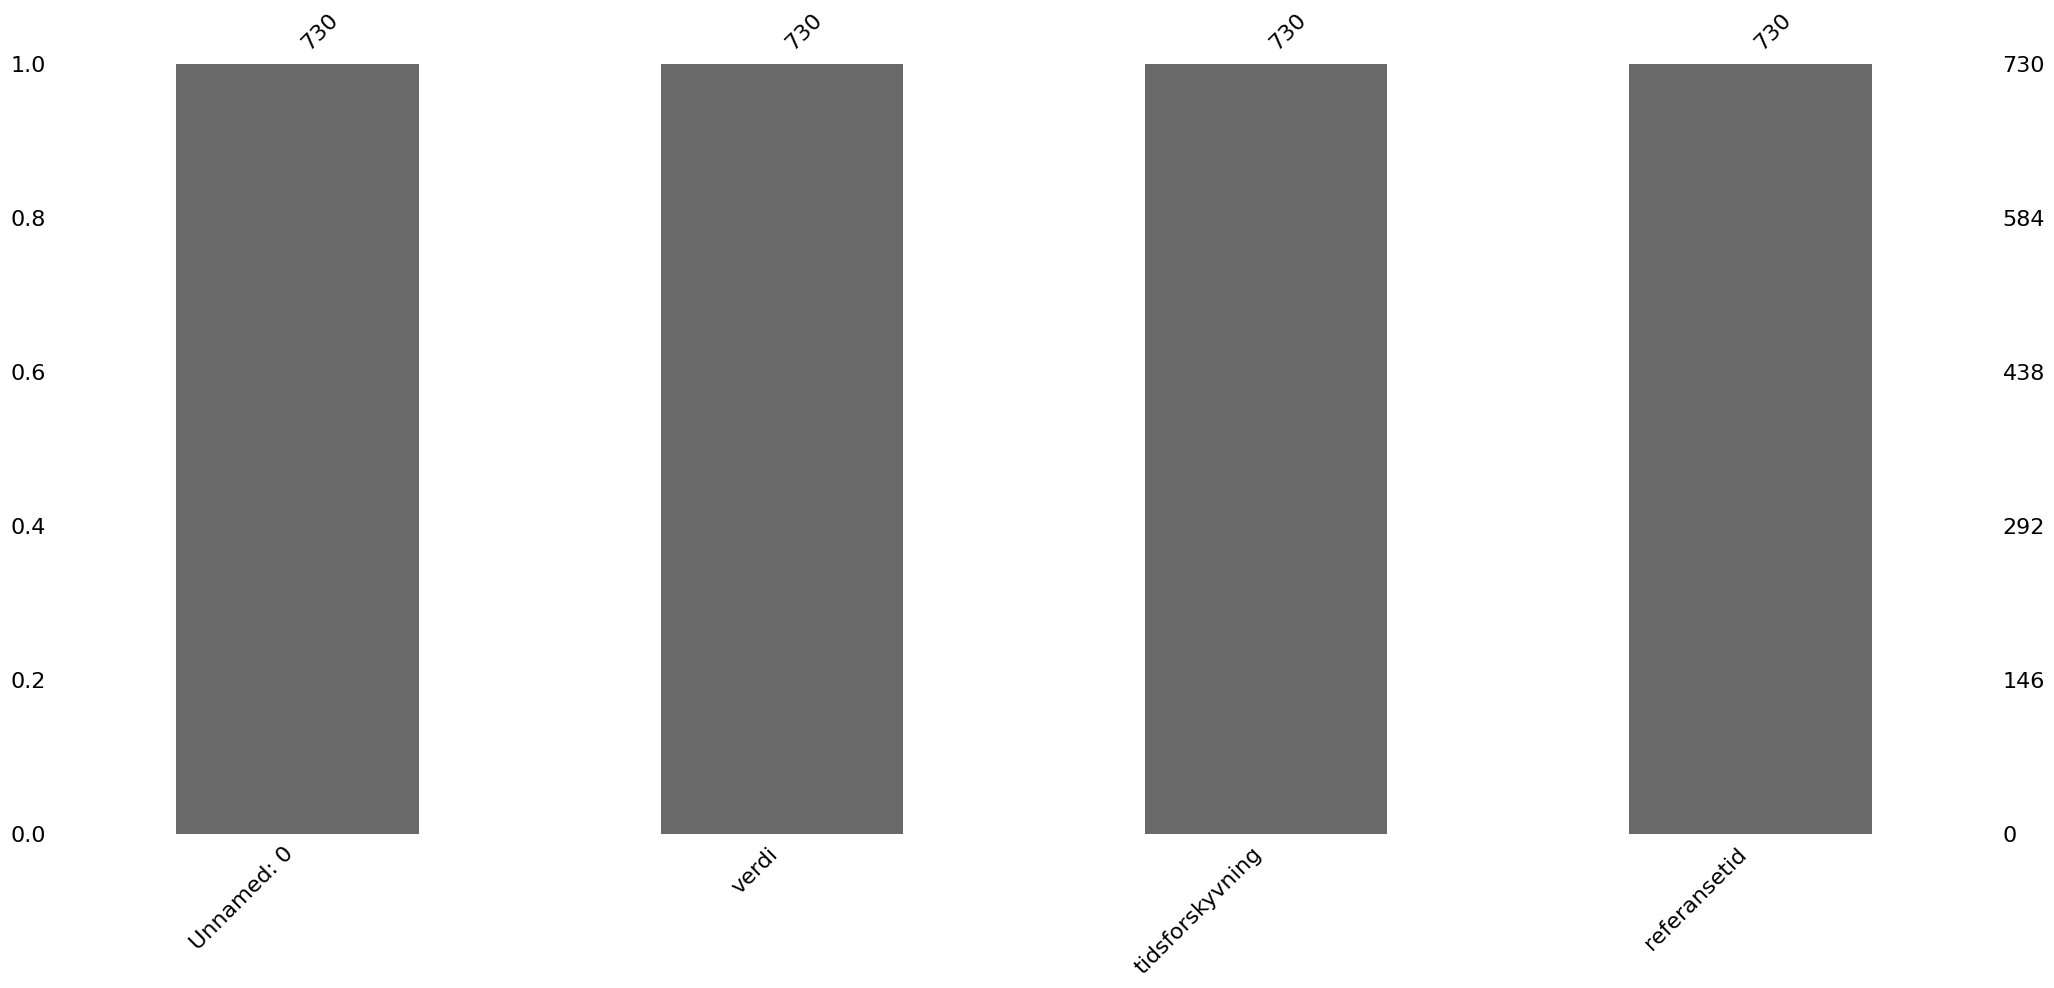

In [8]:
# se om det mangler noen tall i dataen
fc.missing_numbers(wind)

I dette datasettet er det ingen verdier som mangler. 

In [9]:
# Gjøre referansetid om til DateTime
wind['referansetid'] = pd.to_datetime(wind['referansetid'])

# Dataanalyse
#### Median

In [10]:
# Medianen av datasettet
wind_median = fc.median(wind)

Medianen er 2.7


#### Gjennomsnitt

In [11]:
# Gjennomsnitt årlig av datasettet
avg_year = fc.average_year(wind)

Gjennomsnittlig verdi for datasettet er 3.04


In [12]:
# Gjennomsnitt månedlig av datasettet
avg_moth = fc.average_other(wind)
print(avg_moth)

måned
1     3.34
2     3.85
3     2.95
4     3.13
5     2.75
6     2.73
7     2.28
8     2.76
9     2.97
10    3.29
11    3.17
12    3.28
Name: verdi, dtype: float64


#### Standardavvik

In [ ]:
# Standardavvik av datasettet
wind_std = fc.std(wind)

Standardavviket er 1.61


# Visualiere data

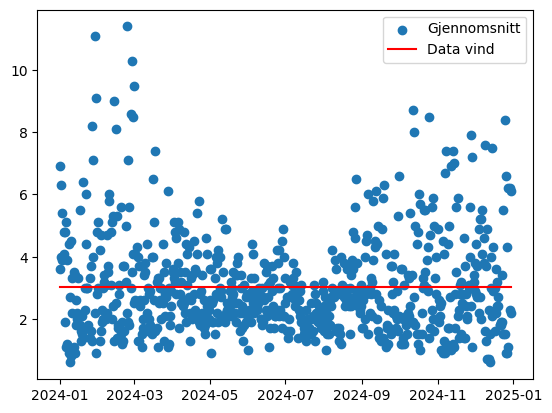

In [40]:
plt.scatter(wind['referansetid'], wind['verdi'])
siste_dato = wind['referansetid'].values[-1]
forste_dato = wind['referansetid'].values[0]
plt.plot([forste_dato, siste_dato], [avg_year, avg_year], color = 'red')
plt.legend(["Gjennomsnitt", "Data vind"])

In [ ]:

plt.bar(avg_moth)

TypeError: bar() missing 1 required positional argument: 'height'

In [41]:
monthly_average = fc.average_other(wind)
months = pd.date_range("15.01.2024", "16.12.2024", periods=12)


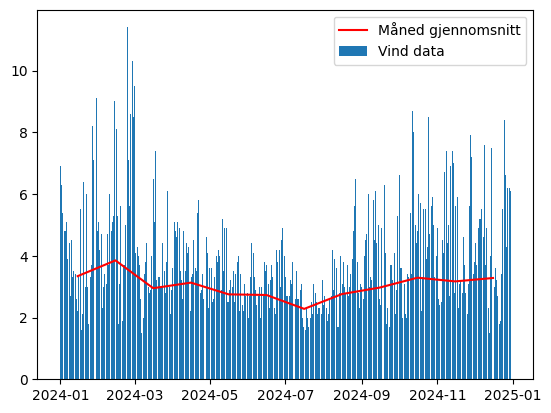

In [ ]:
plt.bar(wind['referansetid'], wind['verdi'].values)
plt.plot(months, monthly_average, color = 'red')
plt.legend(["Måned gjennomsnitt", "Vind data"])